In [1]:
import cv2
import numpy as np
import os 
import dicom
import data
import copy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
nb_classes = 2
RECEP_HEI = 56
RECEP_WEI = 28
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=( 1 , RECEP_HEI, RECEP_WEI)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
#model.fit(X_train, Y_train, batch_size=32, nb_epoch=1,
          #verbose=1, shuffle = True ,validation_split=0.25)

In [3]:
def get_input_and_output(source):
    file = open(source, 'r')
    list = file.readlines()
    test_array = np.empty((0,len(list)), int)
    for line in list:
        #print line
        line = line.split(',')
        line[len(line)-1] = line[len(line)-1].replace('\n','')
        line = map(int, line)
        test_array = np.append(test_array,np.array([line]),axis = 0)
    dir_array = source.split('/')
    dir_name = dir_array[len(dir_array)-1].split('_')
    dir_image_file = DATA_PATH+'/data/Sagittal-segmentation/'+dir_name[0]+'/'+dir_name[1]+'/'+str(dir_name[2]).replace('txt','dcm')
    medical_img=dicom.read_file(dir_image_file)
    return medical_img.pixel_array , test_array

In [5]:
    MODE_TEST_PATH = '/data/metROI/test2_txt'
    DATA_PATH =  os.getcwd()
    IMG_COLS = 320
    IMG_ROWS = 320
    count_img = 0
    count = 0
    index = 0
    count_pos = 0
    class_lable = 2
    x_start = RECEP_WEI 
    y_start = RECEP_HEI 
    y_max = IMG_COLS
    x_max = IMG_ROWS/2
    MODE = 'test'
    if MODE == 'train':
        TRAIN_DATA_TXT_PATH = DATA_PATH + MODE_TRAIN_PATH
    elif MODE == 'test':
        TRAIN_DATA_TXT_PATH = DATA_PATH + MODE_TEST_PATH
    IMG_LIST = os.listdir(TRAIN_DATA_TXT_PATH)
    TRAIN_NUM = len(IMG_LIST)
    #TRAIN_IN = np.ndarray((TRAIN_NUM * 38544, 1, RECEP_WEI, RECEP_HEI), dtype=np.float32)
    #TRAIN_OUT = np.ndarray((TRAIN_NUM * 38544, 2), dtype=np.float32)
    TRAIN_OUT = []
    TRAIN_IN = []
    for name in IMG_LIST:
            med_img , test_array = get_input_and_output(TRAIN_DATA_TXT_PATH + '/' + name)
            test_array = test_array + 0.01
            med_img = cv2.resize(med_img, (IMG_ROWS,IMG_COLS), interpolation = cv2.INTER_AREA)
            test_array = cv2.resize(test_array, (IMG_ROWS,IMG_COLS), interpolation = cv2.INTER_AREA)

    
            cropImg1 = med_img[0:IMG_ROWS, IMG_COLS/4 : 3*IMG_ROWS/4 ]
            cropImg2 = test_array[0:IMG_ROWS, IMG_COLS/4 : 3*IMG_ROWS/4 ]


            for i in range(y_start, y_max):
                for m in range(x_start, x_max):
                    region = cropImg1[i- RECEP_HEI: i, m- RECEP_WEI: m]
                    class_lable = cropImg2[i- RECEP_HEI/2][m- RECEP_WEI/2]
                    if(class_lable != 1.01):
                        TRAIN_IN.append(region.reshape(1,RECEP_HEI, RECEP_WEI))
                        TRAIN_OUT.append(np_utils.to_categorical([0], nb_classes)[0])
                        index += 1
                        #print(index)
                        
                    elif (class_lable == 1.01):
                        TRAIN_IN.append(region.reshape(1,RECEP_HEI, RECEP_WEI))
                        TRAIN_OUT.append(np_utils.to_categorical([1], nb_classes)[0])
                        count_pos += 1
                        index += 1
                        #print(index)
                        
                    count += 1
            if(index%1000 == 0):
                    print('Processed training set:'+str(index))

            count_img += 1
            print('Processed images:'+str(count_img)+'.Positive num:'+str(count_pos)+'.Total size:'+str(index))
    TRAIN_IN = np.asarray(TRAIN_IN, dtype=np.float)
    TRAIN_OUT = np.asarray(TRAIN_OUT, dtype=np.float)

Processed images:1.Positive num:943.Total size:34848


In [6]:
print('Normalizing training data...')
for i in range(TRAIN_IN.shape[0]):
    for m in range(TRAIN_IN.shape[1]):
        mean = np.mean(TRAIN_IN[i][m])  # mean for data centering
        std = np.std(TRAIN_IN[i][m])  # std for data normalization
        TRAIN_IN[i][m] = (TRAIN_IN[i][m] - mean)/std

Normalizing training data...


In [7]:
predict_result = model.predict_classes(TRAIN_IN)

34848/34848 [==============================] - 211s   


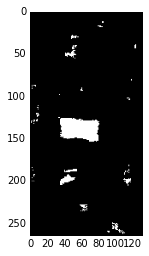

In [8]:
plt.imshow(predict_result.reshape(y_max - y_start,x_max - x_start),'gray')

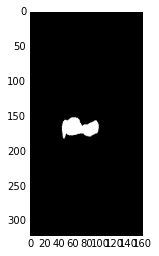

In [9]:
plt.imshow(cropImg2,'gray')

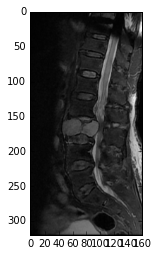

In [10]:
plt.imshow(cropImg1,'gray')